# Детектор финансового мошенничества (IEEE-CIS)

**Кратко:** Пет-проект по детекции мошенничества на датасете IEEE-CIS (Kaggle). Основная метрика — ROC AUC.

**Структура ноутбука**
1. Setup (imports, конфигурация)
2. Data loading
3. EDA
4. Feature engineering (функции)
5. Modeling (+ Optuna, RandomizedSearch)
6. Final training & CV
---

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    LabelEncoder,
    RobustScaler,
    OrdinalEncoder,
    MinMaxScaler,
    StandardScaler
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    train_test_split,
    RandomizedSearchCV
)
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)

import category_encoders as ce
import optuna
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Использование памяти уменьшено на {100 * (start_mem - end_mem) / start_mem:.2f}%')
        print(f'Было: {start_mem:.2f} МБ, Стало: {end_mem:.2f} МБ')
    return df

In [4]:
df_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

In [5]:
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Использование памяти уменьшено на 48.38%
Было: 1775.15 МБ, Стало: 916.30 МБ
Использование памяти уменьшено на 29.27%
Было: 45.12 МБ, Стало: 31.91 МБ


In [6]:
print(df_id.shape)
print(df_trans.shape)

(144233, 41)
(590540, 394)


Ввод Feature Engineering

In [7]:
df_trans.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df_id.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
df = df_trans.merge(df_id, how='left', on='TransactionID')
print(df.shape)

(590540, 434)


Проанализируем таргет

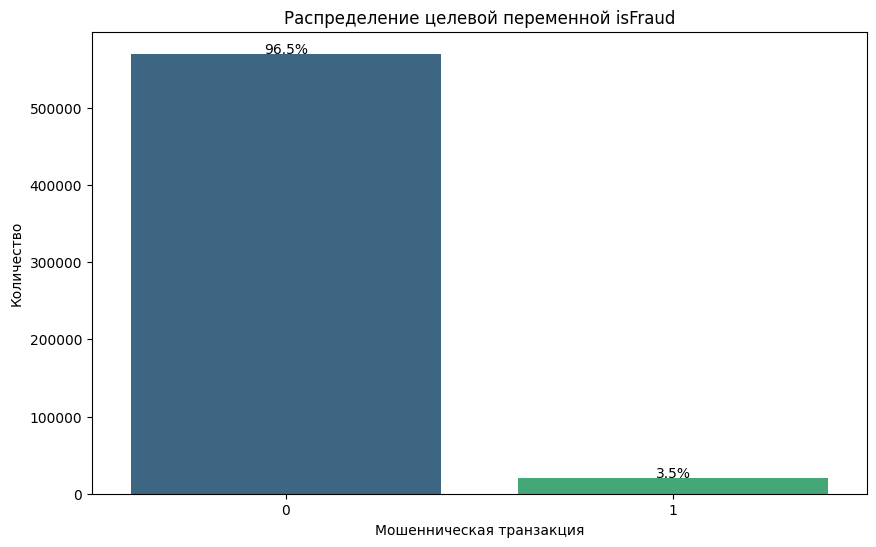

In [8]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='isFraud', data=df, palette='viridis')
plt.title('Распределение целевой переменной isFraud')
plt.xlabel('Мошенническая транзакция')
plt.ylabel('Количество')

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 1000
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

Прослеживается сильный дисбаланс целевой переменной

Проведем feature engineering

In [10]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. ВРЕМЕННЫЕ ФИЧИ
    start = df['TransactionDT'].min()
    df['hour'] = ((df['TransactionDT'] - start) // 3600) % 24
    df['day'] = ((df['TransactionDT'] - start) // (3600*24)) % 7
    df['is_weekend'] = df['day'].isin([5, 6]).astype(int)
    df['is_night'] = df['hour'].between(0, 6).astype(int)

    # 2. СУММА ТРАНЗАКЦИИ
    df['log_amt'] = np.log1p(df['TransactionAmt'])
    df['cents'] = df['TransactionAmt'] % 1
    df['round_amt'] = np.round(df['TransactionAmt'], -2)
    df['is_whole'] = (df['TransactionAmt'] == np.floor(df['TransactionAmt'])).astype(int)

    # 3. DEVICE / BROWSER
    df['is_mobile'] = (df['DeviceType'] == 'mobile').astype(int)
    df['is_ios'] = df['DeviceInfo'].fillna("").str.contains("iOS", case=False).astype(int)
    df['is_android'] = df['DeviceInfo'].fillna("").str.contains("Android", case=False).astype(int)
    df['is_old_device'] = df['DeviceInfo'].fillna("").str.contains("Windows XP|Windows 7|IE 6", case=False).astype(int)

    # 4. EMAIL-ДОМЕНЫ
    free_domains = ['gmail.com', 'yahoo.com', 'hotmail.com', 'outlook.com', 'icloud.com']
    df['is_free_email'] = df['P_emaildomain'].isin(free_domains).astype(int)
    df['same_email'] = (df['P_emaildomain'] == df['R_emaildomain']).astype(int)

    # 5. IDENTITY
    id_cols = [col for col in df.columns if col.startswith('id_')]
    df['id_NA_count'] = df[id_cols].isna().sum(axis=1)

    return df

In [11]:
df = add_features(df)

In [12]:
def add_group_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Считаем кол-во транзакций по card1
    df["card1_count"] = df.groupby("card1")["TransactionID"].transform("count")
    df["card1_day_count"] = df.groupby(["card1", "day"])["TransactionID"].transform("count")
    df["card1_hour_count"] = df.groupby(["card1", "day", "hour"])["TransactionID"].transform("count")

    # Сколько уникальных email на карту
    df["n_email_per_card1"] = df.groupby("card1")["P_emaildomain"].transform("nunique")

    # Сколько уникальных устройств на карту
    df["n_device_per_card1"] = df.groupby("card1")["DeviceInfo"].transform("nunique")

    # Можно расширять аналогично для addr1, R_emaildomain и т.д.
    return df

In [13]:
df = add_group_features(df)

In [14]:
def add_lag_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(["card1", "TransactionDT"]).copy()

    # Разница во времени между транзакциями одной карты
    df["card1_lag_time"] = df.groupby("card1")["TransactionDT"].diff().fillna(-1)

    # Разница в сумме транзакции
    df["card1_lag_amt"] = df.groupby("card1")["TransactionAmt"].diff().fillna(0)

    # Скользящее среднее суммы по карте
    df["card1_amt_mean_3"] = df.groupby("card1")["TransactionAmt"].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df["card1_amt_std_3"] = df.groupby("card1")["TransactionAmt"].transform(lambda x: x.rolling(3, min_periods=1).std())

    return df

In [15]:
df = add_lag_features(df)

In [ ]:
V_cols = [f"V{i}" for i in range(1, 340) if f"V{i}" in df.columns]

df_V = df[V_cols].fillna(-999)

scaler = StandardScaler()
df_V_scaled = scaler.fit_transform(df_V)

pca = PCA(n_components=20, random_state=42)
df_pca = pca.fit_transform(df_V_scaled)

for i in range(20):
    df[f"V_pca_{i}"] = df_pca[:, i]

In [14]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V_pca_10,V_pca_11,V_pca_12,V_pca_13,V_pca_14,V_pca_15,V_pca_16,V_pca_17,V_pca_18,V_pca_19
243924,3230924,0,5787419,23.443,C,1000,555.0,185.0,mastercard,224.0,...,0.721845,-0.160535,-0.082504,0.340965,-0.432336,0.501084,-0.176130,0.053940,0.174905,0.239024
36634,3023634,0,916268,183.000,W,1001,555.0,150.0,visa,226.0,...,0.572354,-0.143361,-0.140420,-0.168543,0.364728,0.239800,-0.042421,0.212547,-0.097778,-0.046446
164336,3151336,0,3504180,29.000,W,1001,555.0,150.0,visa,226.0,...,-1.013252,-0.369563,0.240484,0.279878,-1.125759,-1.156266,0.056515,0.747250,0.005202,0.123698
223739,3210739,0,5270458,27.000,W,1001,555.0,150.0,visa,226.0,...,-1.197330,-0.542866,0.246392,0.138947,0.180562,0.224025,-0.155320,0.211585,0.038430,0.060089
33767,3020767,0,842821,150.000,R,1004,583.0,150.0,visa,226.0,...,0.512265,0.037651,1.279060,-0.760754,-0.457839,0.332196,-0.321863,-0.000921,0.118189,-0.137802


In [24]:
df[['TransactionDT', 'hour', 'day', 'is_weekend', 'is_night']].tail(200)

,TransactionDT,hour,day,is_weekend,is_night
590340,15806729,22,6,1,0
590341,15806734,22,6,1,0
590342,15806750,22,6,1,0
590343,15806757,22,6,1,0
590344,15806846,22,6,1,0
...,...,...,...,...,...
590535,15811047,23,6,1,0
590536,15811049,23,6,1,0
590537,15811079,23,6,1,0
590538,15811088,23,6,1,0


In [61]:
print("Hour distribution:")
print(df['hour'].value_counts().sort_index())

print("\nDay distribution:")
print(df['day'].value_counts().sort_index())

print("\nWeekend share:", df['is_weekend'].mean())
print("Night share:", df['is_night'].mean())

Hour distribution:
hour
0     37795
1     32797
2     26732
3     20802
4     14839
5      9701
6      6007
7      3704
8      2591
9      2479
10     3627
11     6827
12    12451
13    20315
14    28328
15    33859
16    38698
17    40723
18    41639
19    42115
20    41782
21    41641
22    41139
23    39949
Name: count, dtype: int64

Day distribution:
day
0    98502
1    79834
2    70223
3    85433
4    84815
5    85356
6    86377
Name: count, dtype: int64

Weekend share: 0.2908067192738849
Night share: 0.2517577132793714


In [17]:
cat_feat = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain', 'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23',
    'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35',
    'id_36', 'id_37', 'id_38',
    'DeviceType', 'DeviceInfo']

In [18]:
num_feat = [f for f in df.columns if f not in cat_feat]

In [20]:
num_feat[0:10] # check

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4']

In [19]:
df_cat = df[cat_feat]
df_cat.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
243924,C,1000,555.0,185.0,mastercard,224.0,debit,NaN,NaN,gmail.com,...,chrome 63.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3213 Build/36.0.A.2.146
36634,W,1001,555.0,150.0,visa,226.0,debit,269.0,87.0,yahoo.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164336,W,1001,555.0,150.0,visa,226.0,debit,269.0,87.0,yahoo.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223739,W,1001,555.0,150.0,visa,226.0,debit,269.0,87.0,yahoo.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33767,R,1004,583.0,150.0,visa,226.0,credit,299.0,87.0,gmail.com,...,chrome 63.0,24.0,3840x2160,match_status:2,T,F,T,F,desktop,MacOS


In [48]:
df_cat[['ProductCD', 'card4', 'card6']].nunique()

ProductCD    5
card4        4
card6        4
dtype: int64

In [50]:
df_cat[['P_emaildomain', 'R_emaildomain']].nunique()

P_emaildomain    59
R_emaildomain    60
dtype: int64

In [51]:
df_cat.isna().sum()

ProductCD             0
card1                 0
card2              8933
card3              1565
card4              1577
card5              4259
card6              1571
addr1             65706
addr2             65706
P_emaildomain     94456
R_emaildomain    453249
M1               271100
M2               271100
M3               271100
M4               281444
M5               350482
M6               169360
M7               346265
M8               346252
M9               346252
id_12            446307
id_13            463220
id_14            510496
id_15            449555
id_16            461200
id_17            451171
id_18            545427
id_19            451222
id_20            451279
id_21            585381
id_22            585371
id_23            585371
id_24            585793
id_25            585408
id_26            585377
id_27            585371
id_28            449562
id_29            449562
id_30            512975
id_31            450258
id_32            512954
id_33           

In [20]:
df_cat.shape

(590540, 49)

In [21]:
cat_small = ['ProductCD', 'card4', 'card6'] + [f'M{i}' for i in range(1, 10)]
cat_medium = ['card1','card2','card3','card5','addr1','addr2',
              'P_emaildomain','R_emaildomain','DeviceType']
cat_high = ['DeviceInfo'] + [f'id_{i}' for i in range(12,39)]

df_cat = df_cat.fillna("missing")

original_index = df.index.copy()
df_cat.index = original_index

# LabelEncoder
le = LabelEncoder()
for col in cat_small:
    df_cat[col] = le.fit_transform(df_cat[col])

# Средние - частотное кодирование
freq_enc = ce.CountEncoder(cols=cat_medium)
df_cat[cat_medium] = freq_enc.fit_transform(df_cat[cat_medium])

# Большие - hash encoding
hash_enc = ce.HashingEncoder(cols=cat_high, n_components=10)
df_cat = df_cat.join(hash_enc.fit_transform(df_cat[cat_high]))
df_cat = df_cat.drop(columns=cat_high)

In [22]:
cat_feat_new = []

for i in df_cat.columns:
    cat_feat_new.append(i)

In [23]:
cat_feat_new

['ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'DeviceType',
 'col_0',
 'col_1',
 'col_2',
 'col_3',
 'col_4',
 'col_5',
 'col_6',
 'col_7',
 'col_8',
 'col_9']

In [24]:
df = df.drop(columns=cat_feat)

df_final = df.join(df_cat, how='left')

print("\nПроверка размеров:")
print(f"Исходный df: {df.shape}")
print(f"Закодированные категории: {df_cat.shape}") 
print(f"Итоговый датафрейм: {df_final.shape}")

assert len(df_final) == len(df), "Ошибка: количество строк изменилось!"
assert not df_final[df_cat.columns].isnull().all().any(), "Есть полностью пустые колонки"


Проверка размеров:
Исходный df: (590540, 429)
Закодированные категории: (590540, 31)
Итоговый датафрейм: (590540, 460)


In [25]:
num_feat.remove('isFraud')

In [29]:
feat = cat_feat_new + num_feat

In [30]:
num_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_feat)
    ]
)

In [33]:
preprocessor.fit(df_final[feat])

X = preprocessor.transform(df_final[feat])
y = df_final['isFraud'].values


print(X.shape)
print(y.shape)

(590540, 428)
(590540,)


In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


models = {
    "LogReg": LogisticRegression(solver='liblinear', C=10),
    "DecisionTree": DecisionTreeClassifier(min_samples_leaf=4),
    "RandomForest": RandomForestClassifier(random_state=1, n_estimators=100),
    "XGBoost": XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=200, random_state=1)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    # вероятности для класса 1
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    
    print(f"=== {name} ===")
    print("ROC-AUC:", roc_auc_score(y_valid, y_pred_proba))
    print("F1:", f1_score(y_valid, y_pred))
    print("Precision:", precision_score(y_valid, y_pred))
    print("Recall:", recall_score(y_valid, y_pred))
    print()

=== LogReg ===
ROC-AUC: 0.8513281726528017
F1: 0.3619191537589724
Precision: 0.8251507321274764
Recall: 0.2317928865231067

=== DecisionTree ===
ROC-AUC: 0.7857891429342639
F1: 0.55224688684353
Precision: 0.6267281105990783
Recall: 0.4935881925961771

=== RandomForest ===
ROC-AUC: 0.9155437685124894
F1: 0.5829596412556054
Precision: 0.9295550847457628
Recall: 0.4246310186305347

=== XGBoost ===
ROC-AUC: 0.9459076876144994
F1: 0.6633586602574042
Precision: 0.9235751295336787
Recall: 0.5175417372368739

[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.826553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43840
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 426
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> inits

In [ ]:
X_test = preprocessor.transform(test_final[feat])

In [ ]:
test_pred = forest_model.predict_proba(X_test)
print(test_pred[:15])

In [ ]:
submission = pd.DataFrame({
    'TransactionID': test['TransactionID'],
    'isFraud': test_pred[:,1]
})

submission.to_csv('my_submission.csv', index=False)

Добавил новый feat engeer

In [24]:
X = df_final.drop("isFraud", axis=1)
y = df_final["isFraud"]

Возьму разумный стартовый сетап

In [38]:
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 128,
    "max_depth": -1,
    "min_data_in_leaf": 200,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 1.0,
    "lambda_l2": 1.0,
    "metric": "auc",
    "random_state": 42,
    "n_estimators": 2000
}

In [ ]:
some_lgb = lgb.LGBMClassifier(**params)
some_lgb.fit(X, y)
print(some_lgb.score(X, y))

In [42]:
test_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

In [43]:
test = test_trans.merge(test_id, how='left', on='TransactionID')

In [44]:
test = add_features(test)

In [45]:
test = add_group_features(test)

In [46]:
test = add_lag_features(test)

In [ ]:
V_cols = [f"V{i}" for i in range(1, 340) if f"V{i}" in test.columns]

df_V = test[V_cols].fillna(-999)

scaler = StandardScaler()
df_V_scaled = scaler.fit_transform(df_V)

pca = PCA(n_components=20, random_state=42)
df_pca = pca.fit_transform(df_V_scaled)

for i in range(20):
    test[f"V_pca_{i}"] = df_pca[:, i]

In [48]:
test = test.rename(columns={'id-01': 'id_01', 'id-02': 'id_02', 'id-03': 'id_03', 'id-04': 'id_04',
                            'id-05': 'id_05', 'id-06': 'id_06', 'id-07': 'id_07', 'id-08': 'id_08',
                            'id-09': 'id_09', 'id-10': 'id_10', 'id-11': 'id_11', 'id-12': 'id_12',
                            'id-13': 'id_13', 'id-14': 'id_14', 'id-15': 'id_15', 'id-16': 'id_16',
                            'id-17': 'id_17', 'id-18': 'id_18', 'id-19': 'id_19', 'id-20': 'id_20',
                            'id-21': 'id_21', 'id-22': 'id_22', 'id-23': 'id_23', 'id-24': 'id_24',
                            'id-25': 'id_25', 'id-26': 'id_26', 'id-27': 'id_27', 'id-28': 'id_28',
                            'id-29': 'id_29', 'id-30': 'id_30', 'id-31': 'id_31', 'id-32': 'id_32',
                            'id-33': 'id_33', 'id-34': 'id_34', 'id-35': 'id_35', 'id-36': 'id_36',
                            'id-37': 'id_37', 'id-38': 'id_38'})

In [49]:
cat_feat = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain', 'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23',
    'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35',
    'id_36', 'id_37', 'id_38',
    'DeviceType', 'DeviceInfo']

In [50]:
test_cat = test[cat_feat]
test_cat.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
420980,H,1001,555.0,150.0,visa,226.0,debit,269.0,87.0,hotmail.com,...,chrome 70.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
449477,W,1001,555.0,150.0,visa,226.0,debit,269.0,87.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483454,H,1002,NaN,150.0,mastercard,NaN,credit,343.0,87.0,gmail.com,...,mobile safari 12.0,32.0,2436x1125,match_status:2,T,F,F,T,mobile,iOS Device
318073,W,1003,452.0,150.0,mastercard,224.0,debit,264.0,87.0,yahoo.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381391,H,1004,583.0,150.0,visa,226.0,credit,325.0,87.0,aol.com,...,chrome 49.0,24.0,1280x800,match_status:2,T,T,T,T,desktop,Windows


In [51]:
cat_small = ['ProductCD', 'card4', 'card6'] + [f'M{i}' for i in range(1, 10)]
cat_medium = ['card1','card2','card3','card5','addr1','addr2',
              'P_emaildomain','R_emaildomain','DeviceType']
cat_high = ['DeviceInfo'] + [f'id_{i}' for i in range(12,39)]

test_cat = test_cat.fillna("missing")

original_index = test.index.copy()
test_cat.index = original_index

le = LabelEncoder()
for col in cat_small:
    test_cat[col] = le.fit_transform(test_cat[col])

freq_enc = ce.CountEncoder(cols=cat_medium)
test_cat[cat_medium] = freq_enc.fit_transform(test_cat[cat_medium])

hash_enc = ce.HashingEncoder(cols=cat_high, n_components=10)
test_cat = test_cat.join(hash_enc.fit_transform(test_cat[cat_high]))
test_cat = test_cat.drop(columns=cat_high)

In [52]:
test = test.drop(columns=cat_feat)

test_final = test.join(test_cat, how='left')

print("\nПроверка размеров:")
print(f"Исходный df: {test.shape}")
print(f"Закодированные категории: {test_cat.shape}") 
print(f"Итоговый датафрейм: {test_final.shape}")

assert len(test_final) == len(test), "Ошибка: количество строк изменилось!"
assert not test_final[test_cat.columns].isnull().all().any(), "Есть полностью пустые колонки"


Проверка размеров:
Исходный df: (506691, 428)
Закодированные категории: (506691, 31)
Итоговый датафрейм: (506691, 459)


In [54]:
test_pred = some_lgb.predict_proba(test_final)
print(test_pred[:15])

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[[9.99934259e-01 6.57406393e-05]
 [9.98608493e-01 1.39150669e-03]
 [9.61173042e-01 3.88269579e-02]
 [9.99718506e-01 2.81493915e-04]
 [9.99313133e-01 6.86867457e-04]
 [9.99829275e-01 1.70725154e-04]
 [9.96723841e-01 3.27615881e-03]
 [9.94838896e-01 5.16110428e-03]
 [9.97085272e-01 2.91472790e-03]
 [9.99847763e-01 1.5223

In [55]:
submission = pd.DataFrame({
    'TransactionID': test['TransactionID'],
    'isFraud': test_pred[:,1]
})

In [56]:
submission.to_csv('lgb_submis_fe.csv', index=False)

Поиграемся с гиперпараметрами с помощью RandomizeSearchCv

In [35]:
RANDOM_STATE = 42
TARGET = "isFraud"

BASE_PARAMS = dict(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=128,
    max_depth=-1,
    min_data_in_leaf=200,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    lambda_l1=1.0,
    lambda_l2=1.0,
    metric="auc",
    random_state=RANDOM_STATE,
    n_estimators=1000
)

USE_GPU = True

def randomized_search_lgb(train_df, n_iter=15, sample_size=50_000, cv=2, random_state=RANDOM_STATE):
    """RandomizedSearchCV по LightGBM (ускоренный вариант, сэмпл данных + early stopping)."""
    X = train_df.drop(columns=[TARGET])
    y = train_df[TARGET].astype(np.int8)

    if len(X) > sample_size:
        Xs, ys = resample(X, y, n_samples=sample_size, stratify=y, random_state=random_state)
    else:
        Xs, ys = X, y

    params = BASE_PARAMS.copy()
    
    if USE_GPU:
        params.update(dict(device_type="gpu", gpu_platform_id=0, gpu_device_id=0))

    clf = lgb.LGBMClassifier(**params)

    param_dist = {
        "num_leaves": [64, 96, 128, 160],
        "min_data_in_leaf": [100, 200, 400],
        "feature_fraction": [0.7, 0.8, 0.9],
        "bagging_fraction": [0.7, 0.8, 0.9],
        "lambda_l1": [0, 0.5, 1.0],
        "lambda_l2": [0, 0.5, 1.0],
    }

    rs = RandomizedSearchCV(
        clf,
        param_distributions=param_dist,
        n_iter=n_iter,             
        scoring="roc_auc",
        cv=cv,                   
        verbose=2,
        random_state=random_state,
        n_jobs=-1,
    )

    rs.fit(
        Xs, ys,
        eval_set=[(Xs, ys)],           
        eval_metric="auc",
        callbacks=[lgb.early_stopping(100, verbose=False)]  
    )


    print("Best score:", rs.best_score_)
    print("Best params:", rs.best_params_)
    return rs.best_params_

In [ ]:
best_params = randomized_search_lgb(df_final, n_iter=25, sample_size=100_000)

Best score: 0.9209925435661532
Best params: {'num_leaves': 160, 'min_data_in_leaf': 100, 'feature_fraction': 0.9, 'bagging_fraction': 0.9}

Уловили тренды с RandomizedSearchCV: learning_rate=0.03, num_leaves=128, max_depth=12, min_child_samples=40, subsample=0.8, colsample_bytree=0.7

Возьмем их, и добавим к ним остальные фиксированные: objective="binary", metric="auc", n_estimators=2000)

In [40]:
final_params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 160,
    "max_depth": 12,
    "min_data_in_leaf": 100,
    "bagging_fraction": 0.9,
    "feature_fraction": 0.9,
    "random_state": 42,
    "n_estimators": 2000,
}

In [38]:
X = df_final.drop("isFraud", axis=1)
y = df_final["isFraud"]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


rand_model_lgb = lgb.LGBMClassifier(**final_params)
rand_model_lgb.fit(X_train, y_train)
y_pred_proba = rand_model_lgb.predict_proba(X_valid)[:, 1]
y_pred = rand_model_lgb.predict(X_valid)

roc_auc_score(y_valid, y_pred_proba)

ROC-AUC - 0.9696296453939629
уже лучше бейзлайна

In [53]:
test_pred = rand_model_lgb.predict_proba(test_final)
print(test_pred[:15])

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[[9.99978840e-01 2.11601035e-05]
 [9.96834250e-01 3.16574985e-03]
 [9.97764484e-01 2.23551561e-03]
 [9.99993242e-01 6.75834818e-06]
 [9.99900684e-01 9.93155432e-05]
 [9.99734552e-01 2.65447686e-04]
 [9.97055369e-01 2.94463075e-03]
 [9.99472593e-01 5.27407318e-04]
 [9.99899895e-01 1.00105079e-04]
 [9.99952010e-01 4.79903250e-05]
 [9.99690749e-01 3.09251003e-04]
 [9.99837867e-01 1.62133475e-04]
 [9.99198194e-01 8.01805961e-04]
 [9.95271051e-01 4.72894879e-03]
 [9.99775760e-01 2.24239702e-04]]


In [54]:
submission = pd.DataFrame({
    'TransactionID': test['TransactionID'],
    'isFraud': test_pred[:,1]
})

In [55]:
submission.to_csv('lgb_submis_rand.csv', index=False)

Реализуем оптюну для оптимизации гиперпараметров

In [28]:
X = df_final.drop("isFraud", axis=1)
y = df_final["isFraud"]

Выбираем подвыборку данных: например, 15–20% строк (≈90–120k строк) для Optuna.
Оптимизируем гиперпараметры на этом небольшом датасете — trials проходят гораздо быстрее.
После подбора параметров: тренируем финальную модель на полном датасете.

In [ ]:
# Создаём случайную подвыборку 20% для Optuna
sample_frac = 0.2
X_sample = X.sample(frac=sample_frac, random_state=42)
y_sample = y.loc[X_sample.index]

def objective(trial):
    param = {
        "objective": "binary",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 500),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 5),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 1),
        "metric": "auc",
        "verbosity": -1,
        "n_jobs": -1,
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        "gpu_use_dp": False
    }

    auc_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, valid_idx in skf.split(X_sample, y_sample):
        X_train, X_valid = X_sample.iloc[train_idx], X_sample.iloc[valid_idx]
        y_train, y_valid = y_sample.iloc[train_idx], y_sample.iloc[valid_idx]

        dtrain = lgb.Dataset(X_train, y_train)
        dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain)

        model = lgb.train(param,
                          dtrain,
                          num_boost_round=2000,
                          valid_sets=[dvalid],
                          valid_names=['valid'],
                          callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
                         )

        preds = model.predict(X_valid)
        auc_scores.append(roc_auc_score(y_valid, preds))

    return np.mean(auc_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(trial.params)

[I 2025-08-24 17:03:09,010] A new study created in memory with name: no-name-9b396020-3c75-4c0d-b973-fb23edabe8f0


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1111]	valid's auc: 0.918342
Training until validation scores don't improve for 100 rounds


Благодаря Optuna провел оценку метрики, оценил тренды, и применил их ниже

In [ ]:
final_params_after_optuna = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.0133,
    "num_leaves": 166,
    "max_depth": 14,
    "min_data_in_leaf": 321,
    "feature_fraction": 0.807,
    "bagging_fraction": 0.857,
    "bagging_freq": 5,
    "lambda_l1": 0.486,
    "lambda_l2": 0.487,
    "min_gain_to_split": 0.091,
    "metric": "auc",
    "verbosity": -1,
    "n_jobs": -1,
    "device": "gpu",
    "random_state": 42
}

opt_model_lgb = lgb.LGBMClassifier(**final_params_after_optuna)
opt_model_lgb.fit(X, y)

In [35]:
test_pred = opt_model_lgb.predict_proba(test_final)
print(test_pred[:15])

[[0.98534052 0.01465948]
 [0.98470803 0.01529197]
 [0.96169653 0.03830347]
 [0.9879036  0.0120964 ]
 [0.98173055 0.01826945]
 [0.97922184 0.02077816]
 [0.95350595 0.04649405]
 [0.98436026 0.01563974]
 [0.97437825 0.02562175]
 [0.98069296 0.01930704]
 [0.97750605 0.02249395]
 [0.98335446 0.01664554]
 [0.98098022 0.01901978]
 [0.97610843 0.02389157]
 [0.98296405 0.01703595]]


In [36]:
submission = pd.DataFrame({
    'TransactionID': test['TransactionID'],
    'isFraud': test_pred[:,1]
})

In [37]:
submission.to_csv('lgb_submis_optuna.csv', index=False)

Проведем оптимизацию гиперпараметров с помощью оптюны: взяв для этого 3 бустинга

In [34]:
sample_size = 100_000

def objective(trial, model_name, X, y, sample_size=100_000):
    if len(X) > sample_size:
        X_sample = X.sample(n=sample_size, random_state=42)
        y_sample = y.loc[X_sample.index]
    else:
        X_sample = X
        y_sample = y
        
    X_train, X_val, y_train, y_val = train_test_split(
        X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
    )

    if model_name == "lightgbm":
        params = {
            "objective": "binary",
            "boosting_type": "gbdt",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 256),
            "max_depth": trial.suggest_int("max_depth", 6, 16),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 500),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
            "lambda_l1": trial.suggest_float("lambda_l1", 0, 5),
            "lambda_l2": trial.suggest_float("lambda_l2", 0, 5),
            "metric": "auc",
            "device": "gpu",
            "verbosity": -1,
        }
        model = lgb.LGBMClassifier(**params, n_estimators=2000)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric="auc",
                  callbacks=[
                                lgb.early_stopping(100),  
                                lgb.log_evaluation(0)    
                            ]
                )

    elif model_name == "xgboost":
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
            "tree_method": "gpu_hist",
            "objective": "binary:logistic",
            "eval_metric": "auc"
        }
        model = xgb.XGBClassifier(**params, n_estimators=2000, use_label_encoder=False)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=100,
                  verbose=False)

    elif model_name == "catboost":
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "depth": trial.suggest_int("depth", 4, 12),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 5),
            "border_count": trial.suggest_int("border_count", 32, 255)
        }
        model = CatBoostClassifier(
            **params, iterations=2000, eval_metric="AUC",
            task_type="GPU", verbose=False
        )
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    return auc

In [35]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, "lightgbm", X, y, sample_size=sample_size), n_trials=20)
print("Best params:", study.best_trial.params)
print("Best AUC:", study.best_value)

[I 2025-08-25 14:30:37,498] A new study created in memory with name: no-name-afb5310a-74f4-4551-bcb9-9fc1aa978ad6
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[666]	valid_0's auc: 0.925669


[I 2025-08-25 14:31:11,008] Trial 0 finished with value: 0.9256685147401282 and parameters: {'learning_rate': 0.029440404824735464, 'num_leaves': 82, 'max_depth': 9, 'min_data_in_leaf': 261, 'feature_fraction': 0.6773503523837846, 'bagging_fraction': 0.6851398839894045, 'bagging_freq': 6, 'lambda_l1': 4.408937182065273, 'lambda_l2': 3.794386775805616}. Best is trial 0 with value: 0.9256685147401282.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1198]	valid_0's auc: 0.933334


[I 2025-08-25 14:32:07,805] Trial 1 finished with value: 0.9333336355935485 and parameters: {'learning_rate': 0.015479649486089916, 'num_leaves': 251, 'max_depth': 13, 'min_data_in_leaf': 366, 'feature_fraction': 0.6968287764559113, 'bagging_fraction': 0.9262516380634942, 'bagging_freq': 2, 'lambda_l1': 1.8194023135327715, 'lambda_l2': 2.036530398224542}. Best is trial 1 with value: 0.9333336355935485.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[437]	valid_0's auc: 0.931866


[I 2025-08-25 14:32:36,244] Trial 2 finished with value: 0.931866137473446 and parameters: {'learning_rate': 0.03572619076521249, 'num_leaves': 173, 'max_depth': 8, 'min_data_in_leaf': 53, 'feature_fraction': 0.9453797975648115, 'bagging_fraction': 0.7677686252767038, 'bagging_freq': 4, 'lambda_l1': 2.577174393521968, 'lambda_l2': 3.169226139190785}. Best is trial 1 with value: 0.9333336355935485.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[628]	valid_0's auc: 0.931809


[I 2025-08-25 14:33:05,761] Trial 3 finished with value: 0.9318087575834176 and parameters: {'learning_rate': 0.02086142690318453, 'num_leaves': 151, 'max_depth': 10, 'min_data_in_leaf': 283, 'feature_fraction': 0.8455763075373792, 'bagging_fraction': 0.898250590749893, 'bagging_freq': 9, 'lambda_l1': 2.314641247660756, 'lambda_l2': 1.7984237436987454}. Best is trial 1 with value: 0.9333336355935485.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1774]	valid_0's auc: 0.932599


[I 2025-08-25 14:34:19,201] Trial 4 finished with value: 0.9325986229866962 and parameters: {'learning_rate': 0.010701791053404238, 'num_leaves': 239, 'max_depth': 12, 'min_data_in_leaf': 382, 'feature_fraction': 0.6801064558941796, 'bagging_fraction': 0.9013915515264925, 'bagging_freq': 4, 'lambda_l1': 1.3000720746442318, 'lambda_l2': 4.5926313460001875}. Best is trial 1 with value: 0.9333336355935485.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1702]	valid_0's auc: 0.932362


[I 2025-08-25 14:35:42,112] Trial 5 finished with value: 0.9323615221457761 and parameters: {'learning_rate': 0.010626541000430987, 'num_leaves': 165, 'max_depth': 16, 'min_data_in_leaf': 394, 'feature_fraction': 0.703857357564751, 'bagging_fraction': 0.7993041551347013, 'bagging_freq': 6, 'lambda_l1': 1.1157258583942071, 'lambda_l2': 0.11288233848089857}. Best is trial 1 with value: 0.9333336355935485.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[452]	valid_0's auc: 0.931918


[I 2025-08-25 14:36:07,805] Trial 6 finished with value: 0.9319177199134455 and parameters: {'learning_rate': 0.037358659755655894, 'num_leaves': 144, 'max_depth': 12, 'min_data_in_leaf': 233, 'feature_fraction': 0.6412133273268037, 'bagging_fraction': 0.6629958395352922, 'bagging_freq': 6, 'lambda_l1': 0.0840949811930175, 'lambda_l2': 2.5978930808560325}. Best is trial 1 with value: 0.9333336355935485.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[973]	valid_0's auc: 0.923683


[I 2025-08-25 14:36:40,210] Trial 7 finished with value: 0.9236830367578399 and parameters: {'learning_rate': 0.01764617614611336, 'num_leaves': 165, 'max_depth': 7, 'min_data_in_leaf': 202, 'feature_fraction': 0.9752930306311203, 'bagging_fraction': 0.6135096575481036, 'bagging_freq': 10, 'lambda_l1': 3.9058689126649253, 'lambda_l2': 3.11899759007868}. Best is trial 1 with value: 0.9333336355935485.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[659]	valid_0's auc: 0.933705


[I 2025-08-25 14:37:15,493] Trial 8 finished with value: 0.9337050440268017 and parameters: {'learning_rate': 0.02160503128083133, 'num_leaves': 168, 'max_depth': 9, 'min_data_in_leaf': 100, 'feature_fraction': 0.8971262232438615, 'bagging_fraction': 0.9280636443322495, 'bagging_freq': 10, 'lambda_l1': 1.1066603935954107, 'lambda_l2': 4.41149708868359}. Best is trial 8 with value: 0.9337050440268017.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[856]	valid_0's auc: 0.932508


[I 2025-08-25 14:37:55,287] Trial 9 finished with value: 0.9325081679009909 and parameters: {'learning_rate': 0.026113329493905647, 'num_leaves': 53, 'max_depth': 14, 'min_data_in_leaf': 196, 'feature_fraction': 0.7641343428526368, 'bagging_fraction': 0.9733071724752436, 'bagging_freq': 1, 'lambda_l1': 3.120157085709692, 'lambda_l2': 4.768914227996345}. Best is trial 8 with value: 0.9337050440268017.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1979]	valid_0's auc: 0.932693


[I 2025-08-25 14:38:39,230] Trial 10 finished with value: 0.9326933146704994 and parameters: {'learning_rate': 0.014427076253479531, 'num_leaves': 107, 'max_depth': 6, 'min_data_in_leaf': 92, 'feature_fraction': 0.878382494357408, 'bagging_fraction': 0.9938366987035355, 'bagging_freq': 8, 'lambda_l1': 0.06486507935954022, 'lambda_l2': 0.742834228808269}. Best is trial 8 with value: 0.9337050440268017.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1331]	valid_0's auc: 0.931661


[I 2025-08-25 14:39:35,851] Trial 11 finished with value: 0.9316609969339663 and parameters: {'learning_rate': 0.015328524012595716, 'num_leaves': 252, 'max_depth': 14, 'min_data_in_leaf': 492, 'feature_fraction': 0.7724445170810116, 'bagging_fraction': 0.9062598748878055, 'bagging_freq': 2, 'lambda_l1': 1.3283935497043244, 'lambda_l2': 1.635421378553295}. Best is trial 8 with value: 0.9337050440268017.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[354]	valid_0's auc: 0.933087


[I 2025-08-25 14:39:55,379] Trial 12 finished with value: 0.9330865007045017 and parameters: {'learning_rate': 0.048944870574580725, 'num_leaves': 205, 'max_depth': 11, 'min_data_in_leaf': 354, 'feature_fraction': 0.8643592131955735, 'bagging_fraction': 0.8540962004928955, 'bagging_freq': 3, 'lambda_l1': 1.795504102797921, 'lambda_l2': 1.7025313323064402}. Best is trial 8 with value: 0.9337050440268017.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[766]	valid_0's auc: 0.934432


[I 2025-08-25 14:40:54,982] Trial 13 finished with value: 0.9344318807425879 and parameters: {'learning_rate': 0.0205225562587346, 'num_leaves': 211, 'max_depth': 14, 'min_data_in_leaf': 127, 'feature_fraction': 0.9271711854361906, 'bagging_fraction': 0.95382273968789, 'bagging_freq': 8, 'lambda_l1': 0.6941605433161506, 'lambda_l2': 4.019476432365605}. Best is trial 13 with value: 0.9344318807425879.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[776]	valid_0's auc: 0.932504


[I 2025-08-25 14:42:03,257] Trial 14 finished with value: 0.9325041542817402 and parameters: {'learning_rate': 0.021544106968029306, 'num_leaves': 203, 'max_depth': 16, 'min_data_in_leaf': 137, 'feature_fraction': 0.9367799943622742, 'bagging_fraction': 0.8386345879011103, 'bagging_freq': 8, 'lambda_l1': 0.7180475052953685, 'lambda_l2': 4.263068318445634}. Best is trial 13 with value: 0.9344318807425879.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[560]	valid_0's auc: 0.93443


[I 2025-08-25 14:42:30,728] Trial 15 finished with value: 0.9344299482592452 and parameters: {'learning_rate': 0.027107207442094935, 'num_leaves': 204, 'max_depth': 9, 'min_data_in_leaf': 146, 'feature_fraction': 0.9061100092587344, 'bagging_fraction': 0.9589643479820669, 'bagging_freq': 10, 'lambda_l1': 0.6481829346881824, 'lambda_l2': 3.859518004047666}. Best is trial 13 with value: 0.9344318807425879.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[748]	valid_0's auc: 0.936011


[I 2025-08-25 14:43:32,466] Trial 16 finished with value: 0.9360113885702975 and parameters: {'learning_rate': 0.028987124942345142, 'num_leaves': 214, 'max_depth': 15, 'min_data_in_leaf': 158, 'feature_fraction': 0.9964124346987808, 'bagging_fraction': 0.9633054931561865, 'bagging_freq': 8, 'lambda_l1': 0.5741374742371722, 'lambda_l2': 3.5128751041658575}. Best is trial 16 with value: 0.9360113885702975.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[416]	valid_0's auc: 0.929019


[I 2025-08-25 14:44:09,239] Trial 17 finished with value: 0.9290189205727791 and parameters: {'learning_rate': 0.0333173757995924, 'num_leaves': 222, 'max_depth': 15, 'min_data_in_leaf': 162, 'feature_fraction': 0.9772463717752302, 'bagging_fraction': 0.7513409290934827, 'bagging_freq': 8, 'lambda_l1': 0.4748027410088473, 'lambda_l2': 3.4887886028796298}. Best is trial 16 with value: 0.9360113885702975.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's auc: 0.927655


[I 2025-08-25 14:44:31,927] Trial 18 finished with value: 0.9276549589640879 and parameters: {'learning_rate': 0.0480998443010868, 'num_leaves': 188, 'max_depth': 14, 'min_data_in_leaf': 307, 'feature_fraction': 0.9988232393429587, 'bagging_fraction': 0.8557164431694328, 'bagging_freq': 7, 'lambda_l1': 3.3116743231211583, 'lambda_l2': 2.8266128156787738}. Best is trial 16 with value: 0.9360113885702975.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[786]	valid_0's auc: 0.933377


[I 2025-08-25 14:45:34,318] Trial 19 finished with value: 0.9333767448373521 and parameters: {'learning_rate': 0.018053324972203952, 'num_leaves': 115, 'max_depth': 15, 'min_data_in_leaf': 59, 'feature_fraction': 0.8289326087683373, 'bagging_fraction': 0.9961918898446049, 'bagging_freq': 7, 'lambda_l1': 1.8817577721983716, 'lambda_l2': 4.959227965063846}. Best is trial 16 with value: 0.9360113885702975.


Best params: {'learning_rate': 0.028987124942345142, 'num_leaves': 214, 'max_depth': 15, 'min_data_in_leaf': 158, 'feature_fraction': 0.9964124346987808, 'bagging_fraction': 0.9633054931561865, 'bagging_freq': 8, 'lambda_l1': 0.5741374742371722, 'lambda_l2': 3.5128751041658575}
Best AUC: 0.9360113885702975


In [36]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, "xgboost", X, y, sample_size=sample_size), n_trials=20)
print("Best params:", study.best_trial.params)
print("Best AUC:", study.best_value)

[I 2025-08-25 14:45:34,325] A new study created in memory with name: no-name-b80785c0-1e83-49b1-aaeb-ced6f71a2cea
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:45:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:45:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device 

Best params: {'learning_rate': 0.038924517553740566, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.8954073766500984, 'colsample_bytree': 0.9318017548521544, 'reg_alpha': 0.9887519484677387, 'reg_lambda': 0.4235331143077889}
Best AUC: 0.9339380940853301


In [37]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, "catboost", X, y, sample_size=sample_size), n_trials=20)
print("Best params:", study.best_trial.params)
print("Best AUC:", study.best_value)

[I 2025-08-25 14:51:10,221] A new study created in memory with name: no-name-e6640e4f-97c6-4007-a9c9-9aceeffd5c28
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-08-25 14:52:00,958] Trial 0 finished with value: 0.8922512695114851 and parameters: {'learning_rate': 0.012870664012488526, 'depth': 6, 'l2_leaf_reg': 5.760577193807542, 'bagging_temperature': 3.9121246440838107, 'border_count': 252}. Best is trial 0 with value: 0.8922512695114851.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-08-25 14:52:59,900] Trial 1 finished with value: 0.9243435001034251 and parameters: {'learning_rate': 0.05812702342808859, 'depth': 12, 'l2_leaf_reg': 2.3572097479740206, 'bagging_temperature': 1.5378583651081716, 'border_count': 100}. Best is trial 1 with value: 0.9243435001034251.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-08-25 14:53:15,795] Trial 2 finished with value: 0.9196963979476729 and parameters: {

Best params: {'learning_rate': 0.04162188851311028, 'depth': 10, 'l2_leaf_reg': 4.52667717919801, 'bagging_temperature': 0.622270295297878, 'border_count': 177}
Best AUC: 0.9307936835444063


Исходя из этих параметров сделаем Блендинг

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

lgb_model = lgb.LGBMClassifier(
    learning_rate=0.028987124942345142,
    num_leaves=214,
    max_depth=15,
    min_data_in_leaf=158,
    feature_fraction=0.9964124346987808,
    bagging_fraction=0.9633054931561865,
    bagging_freq=8,
    lambda_l1=0.5741374742371722,
    lambda_l2=3.5128751041658575,
    n_estimators=2000,
    device='gpu'
)

xgb_model = xgb.XGBClassifier(
    learning_rate=0.038924517553740566,
    max_depth=7,
    min_child_weight=4,
    subsample=0.8954073766500984,
    colsample_bytree=0.9318017548521544,
    reg_alpha=0.9887519484677387,
    reg_lambda=0.4235331143077889,
    n_estimators=2000,
    use_label_encoder=False,
    tree_method='gpu_hist'
)

cat_model = CatBoostClassifier(
    learning_rate=0.04162188851311028,
    depth=10,
    l2_leaf_reg=4.52667717919801,
    bagging_temperature=0.622270295297878,
    border_count=177,
    iterations=2000,
    eval_metric='AUC',
    task_type='GPU',
    verbose=0
)

In [40]:
lgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1689]	valid_0's auc: 0.968775	valid_0's binary_logloss: 0.0507857


LGBMClassifier(bagging_fraction=0.9633054931561865, bagging_freq=8,
               device='gpu', feature_fraction=0.9964124346987808,
               lambda_l1=0.5741374742371722, lambda_l2=3.5128751041658575,
               learning_rate=0.028987124942345142, max_depth=15,
               min_data_in_leaf=158, n_estimators=2000, num_leaves=214)

In [44]:
lgb_pred = lgb_model.predict_proba(X_val)[:, 1]

In [41]:
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:32:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9318017548521544, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.038924517553740566,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [45]:
xgb_pred = xgb_model.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:49:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [42]:
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

Default metric period is 5 because AUC is/are not implemented for GPU


In [46]:
cat_pred = cat_model.predict_proba(X_val)[:, 1]

In [47]:
# Blending
blend_pred = (lgb_pred + xgb_pred + cat_pred) / 3
auc_blend = roc_auc_score(y_val, blend_pred)
print("Blended AUC:", auc_blend)

Blended AUC: 0.965598425716287


In [59]:
lgb_test_pred = lgb_model.predict_proba(test_final)[:, 1]
xgb_test_pred = xgb_model.predict_proba(test_final)[:, 1]
cat_test_pred = cat_model.predict_proba(test_final)[:, 1]

blend_test_pred = (lgb_test_pred + xgb_test_pred + cat_test_pred) / 3

In [60]:
sub = pd.DataFrame({
    "TransactionID": test["TransactionID"],
    "isFraud": blend_test_pred
})

In [61]:
sub.to_csv("submission_blend_3_model.csv", index=False)

Релизуем стекинг с 3мя моделями и гиперпараметрами

In [64]:
# Параметры моделей из Optuna
lgb_params = {
    'learning_rate': 0.028987124942345142,
    'num_leaves': 214,
    'max_depth': 15,
    'min_data_in_leaf': 158,
    'feature_fraction': 0.9964124346987808,
    'bagging_fraction': 0.9633054931561865,
    'bagging_freq': 8,
    'lambda_l1': 0.5741374742371722,
    'lambda_l2': 3.5128751041658575,
    'n_estimators': 2000,
    'device': 'gpu'
}

xgb_params = {
    'learning_rate': 0.038924517553740566,
    'max_depth': 7,
    'min_child_weight': 4,
    'subsample': 0.8954073766500984,
    'colsample_bytree': 0.9318017548521544,
    'reg_alpha': 0.9887519484677387,
    'reg_lambda': 0.4235331143077889,
    'n_estimators': 2000,
    'use_label_encoder': False,
    'tree_method': 'gpu_hist'
}

cat_params = {
    'learning_rate': 0.04162188851311028,
    'depth': 10,
    'l2_leaf_reg': 4.52667717919801,
    'bagging_temperature': 0.622270295297878,
    'border_count': 177,
    'iterations': 2000,
    'task_type': 'GPU',
    'verbose': 0
}

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

oof_preds = np.zeros((len(X), 3))
test_preds = np.zeros((len(test_final), 3))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}/{n_folds}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )
    oof_preds[val_idx, 0] = lgb_model.predict_proba(X_val)[:, 1]
    test_preds[:, 0] += lgb_model.predict_proba(test_final)[:, 1] / n_folds

    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=100,
        verbose=False
    )
    oof_preds[val_idx, 1] = xgb_model.predict_proba(X_val)[:, 1]
    test_preds[:, 1] += xgb_model.predict_proba(test_final)[:, 1] / n_folds

    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)
    oof_preds[val_idx, 2] = cat_model.predict_proba(X_val)[:, 1]
    test_preds[:, 2] += cat_model.predict_proba(test_final)[:, 1] / n_folds

Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1688]	valid_0's auc: 0.970779	valid_0's binary_logloss: 0.0499671


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:19:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:20:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1536]	valid_0's auc: 0.967013	valid_0's binary_logloss: 0.0503469


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:30:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:32:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1656]	valid_0's auc: 0.969218	valid_0's binary_logloss: 0.0505417


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:42:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:44:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1625]	valid_0's auc: 0.969193	valid_0's binary_logloss: 0.0486293


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:54:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:56:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1616]	valid_0's auc: 0.968737	valid_0's binary_logloss: 0.0514723


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:06:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:07:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [65]:
meta_model = LogisticRegression()
meta_model.fit(oof_preds, y)

stacked_pred = meta_model.predict_proba(test_preds)[:, 1]

In [67]:
sub = pd.DataFrame({
    "TransactionID": test["TransactionID"],
    "isFraud": stacked_pred
})

In [69]:
sub.to_csv("submission_stack_3_model.csv", index=False)